# Base inicial

In [1]:
import pandas as pd
import datetime 
import numpy as np
import time
from unidecode import unidecode
import pickle


from sklearn.preprocessing import StandardScaler
from pandasql import sqldf
from sklearn.preprocessing import OneHotEncoder

In [26]:
df_inicial = pd.read_csv('./focos_qmd_inpe_2025-02-01_2025-04-30_32.620337.csv')


# Primeiro, garante que a coluna 'DataHora' está no tipo datetime
df_inicial["DataHora"] = pd.to_datetime(df_inicial["DataHora"])

In [30]:
display(df_inicial)

,DataHora,Satelite,Pais,Estado,Municipio,Bioma,DiaSemChuva,Precipitacao,RiscoFogo,Latitude,Longitude,FRP
0,2025-02-01 00:40:00,GOES-16,Brasil,RORAIMA,CARACARAÍ,Amazônia,3.0,0.0,0.60,1.4134,-59.9504,44.9
1,2025-02-01 00:30:00,GOES-16,Brasil,RORAIMA,CARACARAÍ,Amazônia,3.0,0.0,0.60,1.4134,-59.9504,93.2
2,2025-02-01 00:30:00,GOES-16,Brasil,RORAIMA,CARACARAÍ,Amazônia,3.0,0.0,0.60,1.4134,-59.9694,41.0
3,2025-02-01 00:30:00,GOES-16,Brasil,RORAIMA,CARACARAÍ,Amazônia,3.0,0.0,0.61,1.4134,-59.9314,36.9
4,2025-02-01 00:30:00,GOES-16,Brasil,RORAIMA,CARACARAÍ,Amazônia,3.0,0.0,0.61,1.4316,-59.9503,51.9
...,...,...,...,...,...,...,...,...,...,...,...,...
119835,2025-04-30 22:50:00,GOES-19,Brasil,PIAUÍ,OEIRAS,Caatinga,5.0,0.0,0.81,-6.7053,-42.1234,66.0
119836,2025-04-30 22:40:00,GOES-19,Brasil,PIAUÍ,OEIRAS,Caatinga,5.0,0.0,0.81,-6.7053,-42.1234,68.9
119837,2025-04-30 22:40:00,GOES-19,Brasil,PARÁ,SANTA MARIA DAS BARREIRAS,Amazônia,2.0,0.0,0.33,-8.8530,-49.8843,83.5
119838,2025-04-30 23:10:00,GOES-19,Brasil,PIAUÍ,OEIRAS,Caatinga,5.0,0.0,0.81,-6.7053,-42.1234,58.9


In [40]:
df_inicial['ano'] = df_inicial['DataHora'].dt.year
df_inicial['mes'] = df_inicial['DataHora'].dt.month


query = """

    SELECT 
        (ano * 100) + mes as ano_mes,
        Estado,
        DiaSemChuva,
        Precipitacao,
        FRP,
        Bioma,
        CASE WHEN RiscoFogo = 1.0 THEN 1 ELSE 0 END AS target_fogo,
        Latitude,
        Longitude
        
        
    FROM df_inicial

"""


df_inicial_target = sqldf(query, locals())

In [41]:
def normalizar_estado(estado):
    estado = estado.strip()  # Remove espaços extras nas extremidades
    estado = unidecode(estado)  # Remove acentos
    estado = estado.replace(' ', '_')  # Substitui espaços por underscores (opcional)
    return estado.upper()  # Converte para letras maiúsculas


In [42]:
df_inicial_target['Estado'] = df_inicial_target['Estado'].apply(normalizar_estado)

# Pre processamento dos dados

In [34]:
for coluna in df_inicial_target.columns:
    percentual_nulos = df_inicial_target[coluna].isnull().mean() * 100
    mensagem = f"Coluna '{coluna}': {percentual_nulos:.2f}% de nulos"
    if percentual_nulos > 20:
        mensagem += " --> Alerta de variável NULA"
    print(mensagem)
    time.sleep(0.5)  # pausa de meio segundo

Coluna 'ano_mes': 0.00% de nulos
Coluna 'Estado': 0.00% de nulos
Coluna 'DiaSemChuva': 6.37% de nulos
Coluna 'Precipitacao': 6.37% de nulos
Coluna 'FRP': 1.90% de nulos
Coluna 'Bioma': 0.00% de nulos
Coluna 'Latitude': 0.00% de nulos
Coluna 'Longitude': 0.00% de nulos
Coluna 'target_fogo': 0.00% de nulos


In [43]:


# Cria o encoder
encoder = OneHotEncoder(sparse_output=False)

# Aplica o encoding nas colunas categóricas
dummies = encoder.fit_transform(df_inicial_target[['Estado', 'Bioma']])
dummies_df = pd.DataFrame(dummies, columns=encoder.get_feature_names_out(['Estado', 'Bioma']))
df_pre_processado = pd.concat([df_inicial_target, dummies_df], axis=1)

# Remove as colunas originais 'Estado' e 'Bioma'
df_pre_processado = df_pre_processado.drop(axis=1, labels=['Estado', 'Bioma'])

# --- Aqui começa a nova lógica para nulos ---

# Primeiro, substitui nulos na coluna 'target_fogo' por 0
if 'target_fogo' in df_pre_processado.columns:
    df_pre_processado['target_fogo'] = df_pre_processado['target_fogo'].fillna(0)

# Para todas as outras colunas (menos 'target_fogo'), preenche nulos com -999
for coluna in df_pre_processado.columns:
    if coluna != 'target_fogo':
        df_pre_processado[coluna] = df_pre_processado[coluna].fillna(-999)


In [44]:
display(df_inicial_target)

,ano_mes,Estado,DiaSemChuva,Precipitacao,FRP,Bioma,target_fogo,Latitude,Longitude
0,202502,RORAIMA,3.0,0.0,44.9,Amazônia,0,1.4134,-59.9504
1,202502,RORAIMA,3.0,0.0,93.2,Amazônia,0,1.4134,-59.9504
2,202502,RORAIMA,3.0,0.0,41.0,Amazônia,0,1.4134,-59.9694
3,202502,RORAIMA,3.0,0.0,36.9,Amazônia,0,1.4134,-59.9314
4,202502,RORAIMA,3.0,0.0,51.9,Amazônia,0,1.4316,-59.9503
...,...,...,...,...,...,...,...,...,...
119835,202504,PIAUI,5.0,0.0,66.0,Caatinga,0,-6.7053,-42.1234
119836,202504,PIAUI,5.0,0.0,68.9,Caatinga,0,-6.7053,-42.1234
119837,202504,PARA,2.0,0.0,83.5,Amazônia,0,-8.8530,-49.8843
119838,202504,PIAUI,5.0,0.0,58.9,Caatinga,0,-6.7053,-42.1234


## carrega modelo para escoragem


In [8]:
with open('../random_forest_model.pkl', 'rb') as file:
    rf_clf = pickle.load(file)

In [9]:
with open('../decision_tre.pkl', 'rb') as file:
    dt_clf = pickle.load(file)

In [10]:
cols_in = ['DiaSemChuva', 'Precipitacao', 'FRP', 'Estado_ACRE', 'Estado_ALAGOAS', 'Estado_AMAPA',
       'Estado_AMAZONAS', 'Estado_BAHIA', 'Estado_CEARA',
       'Estado_DISTRITO_FEDERAL', 'Estado_ESPIRITO_SANTO', 'Estado_GOIAS',
       'Estado_MARANHAO', 'Estado_MATO_GROSSO', 'Estado_MATO_GROSSO_DO_SUL',
       'Estado_MINAS_GERAIS', 'Estado_PARA', 'Estado_PARAIBA', 'Estado_PARANA',
       'Estado_PERNAMBUCO', 'Estado_PIAUI', 'Estado_RIO_DE_JANEIRO',
       'Estado_RIO_GRANDE_DO_NORTE', 'Estado_RIO_GRANDE_DO_SUL',
       'Estado_RONDONIA', 'Estado_RORAIMA', 
       'Estado_SAO_PAULO', 'Estado_SERGIPE', 'Estado_TOCANTINS',
       'Bioma_Amazônia', 'Bioma_Caatinga', 'Bioma_Cerrado',
       'Bioma_Mata Atlântica', 'Bioma_Pampa']

In [45]:
x = df_pre_processado[cols_in]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

y_pred_rf = dt_clf.predict(x_scaled)

df_inicial_target["target_predita"] = y_pred_rf


In [17]:
x = df_inicial_target['Estado'].unique().tolist()
print(x)

['RORAIMA', 'BAHIA', 'ALAGOAS', 'PERNAMBUCO', 'PIAUI', 'SERGIPE', 'PARAIBA', 'CEARA', 'RIO_GRANDE_DO_NORTE', 'ESPIRITO_SANTO', 'MINAS_GERAIS', 'RIO_GRANDE_DO_SUL', 'MATO_GROSSO_DO_SUL', 'MATO_GROSSO', 'AMAZONAS', 'RONDONIA', 'RIO_DE_JANEIRO', 'PARA', 'PARANA', 'TOCANTINS', 'MARANHAO', 'SANTA_CATARINA', 'GOIAS', 'SAO_PAULO', 'ACRE', 'AMAPA', 'DISTRITO_FEDERAL']


In [46]:
display(df_inicial_target)

,ano_mes,Estado,DiaSemChuva,Precipitacao,FRP,Bioma,target_fogo,Latitude,Longitude,target_predita
0,202502,RORAIMA,3.0,0.0,44.9,Amazônia,0,1.4134,-59.9504,0
1,202502,RORAIMA,3.0,0.0,93.2,Amazônia,0,1.4134,-59.9504,0
2,202502,RORAIMA,3.0,0.0,41.0,Amazônia,0,1.4134,-59.9694,0
3,202502,RORAIMA,3.0,0.0,36.9,Amazônia,0,1.4134,-59.9314,0
4,202502,RORAIMA,3.0,0.0,51.9,Amazônia,0,1.4316,-59.9503,0
...,...,...,...,...,...,...,...,...,...,...
119835,202504,PIAUI,5.0,0.0,66.0,Caatinga,0,-6.7053,-42.1234,1
119836,202504,PIAUI,5.0,0.0,68.9,Caatinga,0,-6.7053,-42.1234,1
119837,202504,PARA,2.0,0.0,83.5,Amazônia,0,-8.8530,-49.8843,1
119838,202504,PIAUI,5.0,0.0,58.9,Caatinga,0,-6.7053,-42.1234,1


In [38]:
df_inicial_target.to_csv('dados_preditos.csv')

C:\Users\Matheus Coffers\AppData\Local\Temp\ipykernel_14832\501233484.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["target_fogo"] == x["target_predita"]).mean())


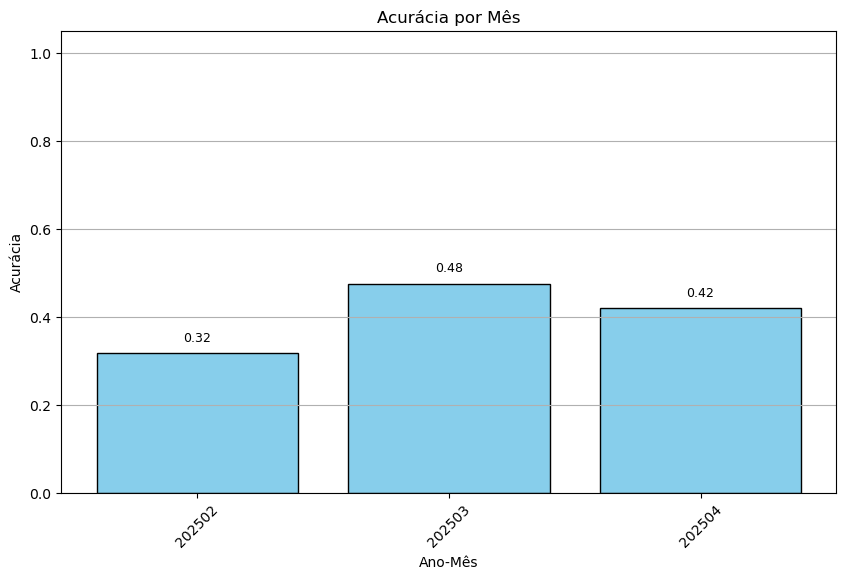

In [141]:
import matplotlib.pyplot as plt
import pandas as pd

# Calcula a acurácia para cada mês
acuracias = (
    df_pre_processado.groupby("ano_mes")
    .apply(lambda x: (x["target_fogo"] == x["target_predita"]).mean())
    .reset_index(name="Acuracia")
)

# Converte 'ano_mes' para string para o plot ficar mais bonito
acuracias["ano_mes"] = acuracias["ano_mes"].astype(str)

# Plotando gráfico de barras
plt.figure(figsize=(10,6))
bars = plt.bar(acuracias["ano_mes"], acuracias["Acuracia"], color='skyblue', edgecolor='black')

# Título e eixos
plt.title("Acurácia por Mês")
plt.xlabel("Ano-Mês")
plt.ylabel("Acurácia")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=45)

# Adicionando os valores de acurácia em cima das barras
for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 0.02, f'{altura:.2f}', 
             ha='center', va='bottom', fontsize=9)

plt.show()


<Figure size 1200x800 with 0 Axes>

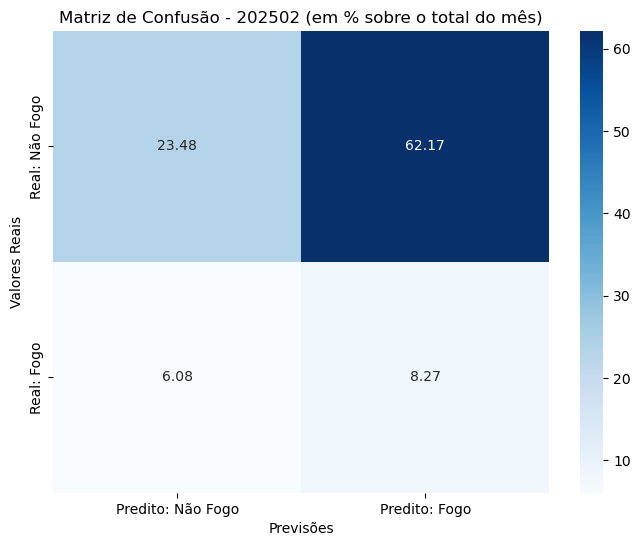

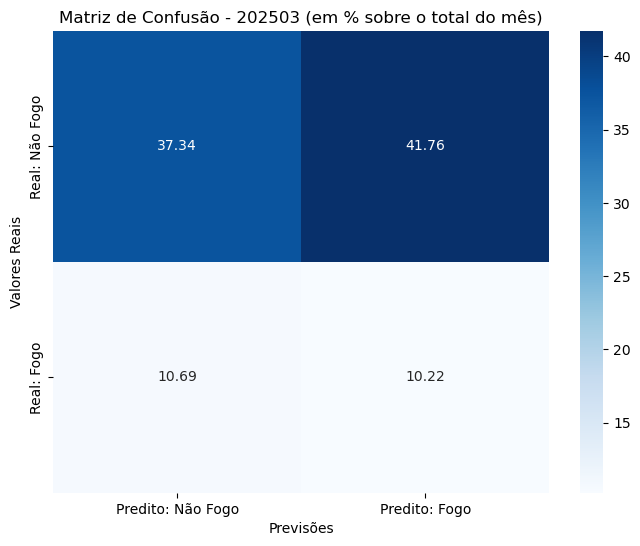

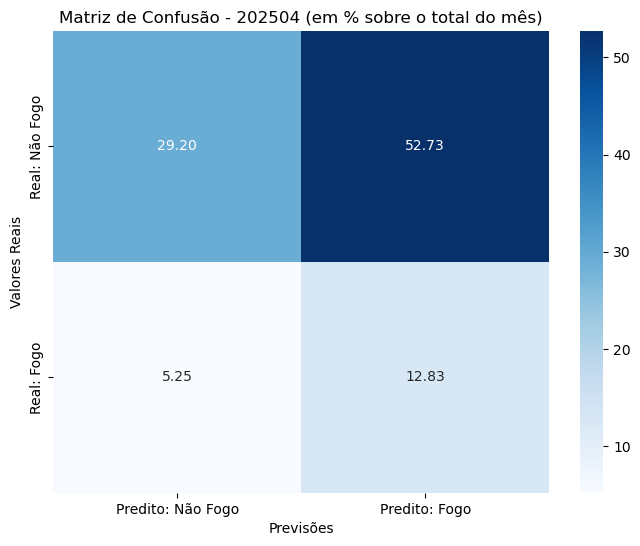

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Garante que 'ano_mes' está como string
df_pre_processado["ano_mes"] = df_pre_processado["ano_mes"].astype(str)

# Lista única de meses
meses = df_pre_processado["ano_mes"].unique()

# Configurações do matplotlib para o gráfico
plt.figure(figsize=(12, 8))

# Loop para gerar heatmap da matriz de confusão para cada mês
for mes in meses:
    df_mes = df_pre_processado[df_pre_processado["ano_mes"] == mes]
    
    # Matriz de confusão
    cm = confusion_matrix(df_mes["target_fogo"], df_mes["target_predita"])
    
    # Convertendo para porcentagem sobre o total do mês
    cm_percentual = cm.astype('float') / cm.sum() * 100  # Soma total de todos os elementos do mês
    
    # Plotando o heatmap com porcentagem sobre o total
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentual, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=["Predito: Não Fogo", "Predito: Fogo"], 
                yticklabels=["Real: Não Fogo", "Real: Fogo"])
    plt.title(f'Matriz de Confusão - {mes} (em % sobre o total do mês)')
    plt.xlabel('Previsões')
    plt.ylabel('Valores Reais')
    plt.show()
